Logistic Regression
               precision    recall  f1-score   support

           0       0.89      0.86      0.88        29
           1       0.88      0.91      0.89        32

    accuracy                           0.89        61
   macro avg       0.89      0.88      0.88        61
weighted avg       0.89      0.89      0.89        61

SVM
               precision    recall  f1-score   support

           0       0.87      0.93      0.90        29
           1       0.93      0.88      0.90        32

    accuracy                           0.90        61
   macro avg       0.90      0.90      0.90        61
weighted avg       0.90      0.90      0.90        61

Random Forest
               precision    recall  f1-score   support

           0       0.84      0.93      0.89        29
           1       0.93      0.84      0.89        32

    accuracy                           0.89        61
   macro avg       0.89      0.89      0.89        61
weighted avg       0.89      0.89

c:\Users\admin\anaconda3\envs\ustaad2\lib\site-packages\xgboost\core.py:158: UserWarning: [16:26:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


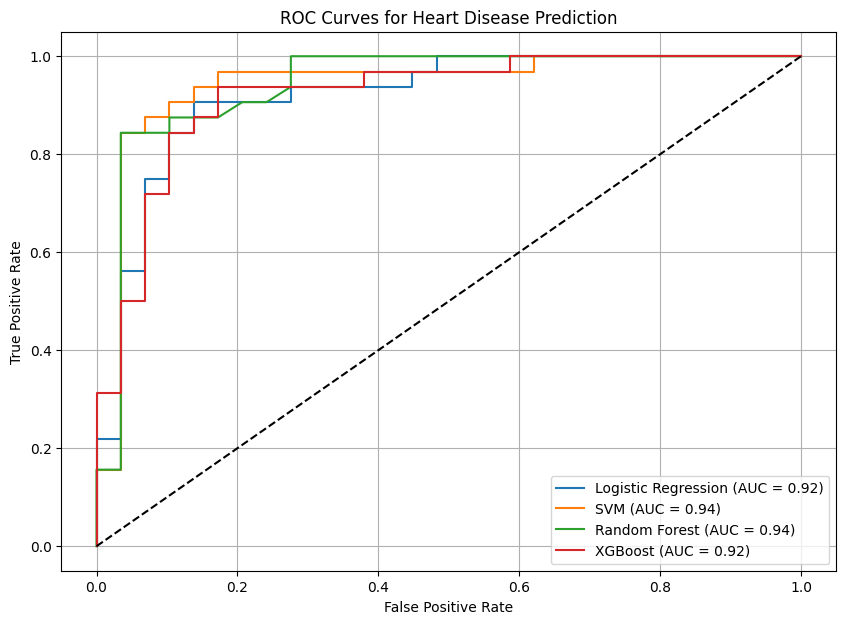

In [22]:
# Required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from ucimlrepo import fetch_ucirepo

# Fetch dataset from UCI
heart_disease = fetch_ucirepo(id=45)

# Extract features and target
X = heart_disease.data.features
y = heart_disease.data.targets

# Flatten y if it's a DataFrame
if isinstance(y, pd.DataFrame):
    y = y.iloc[:, 0]

# ✅ Convert to binary classification: 0 = no disease, 1 = has disease
y = (y > 0).astype(int)

# Handle missing values using mean imputation
imputer = SimpleImputer(strategy='mean')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.2, random_state=42)

# Standardize features for non-tree models
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Store results
results = {}

# 1. Logistic Regression
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train_scaled, y_train)
y_pred_lr = log_reg.predict(X_test_scaled)
results['Logistic Regression'] = classification_report(y_test, y_pred_lr, output_dict=True)
print("Logistic Regression\n", classification_report(y_test, y_pred_lr))

# 2. SVM
svm = SVC(probability=True)
svm.fit(X_train_scaled, y_train)
y_pred_svm = svm.predict(X_test_scaled)
results['SVM'] = classification_report(y_test, y_pred_svm, output_dict=True)
print("SVM\n", classification_report(y_test, y_pred_svm))

# 3. Random Forest
rf = RandomForestClassifier()
rf.fit(X_train, y_train)  # No scaling needed
y_pred_rf = rf.predict(X_test)
results['Random Forest'] = classification_report(y_test, y_pred_rf, output_dict=True)
print("Random Forest\n", classification_report(y_test, y_pred_rf))

# 4. XGBoost
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)
results['XGBoost'] = classification_report(y_test, y_pred_xgb, output_dict=True)
print("XGBoost\n", classification_report(y_test, y_pred_xgb))

# ROC Curves
plt.figure(figsize=(10, 7))

models = {
    "Logistic Regression": (log_reg, X_test_scaled),
    "SVM": (svm, X_test_scaled),
    "Random Forest": (rf, X_test),
    "XGBoost": (xgb, X_test)
}

for name, (model, X_t) in models.items():
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_t)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        auc_score = roc_auc_score(y_test, y_prob)
        plt.plot(fpr, tpr, label=f"{name} (AUC = {auc_score:.2f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for Heart Disease Prediction")
plt.legend()
plt.grid()
plt.show()
